# Netflix Analysis "What we watched 2023" 
## Netflix Statistics Analysis Hours Viewed Jan-Jun 2023
## Dataset source: https://about.netflix.com/en/news/what-we-watched-a-netflix-engagement-report

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import datetime as dt

import statsmodels.api
import statsmodels.api as sm

import re
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Import dataset
df = pd.read_csv("What_We_Watched_A_Netflix_Engagement_Report_2023Jan-Jun.csv", delimiter = ";")
df.head()

,Title,Available Globally?,Release Date,Hours Viewed
0,The Night Agent: Season 1,Yes,23.03.2023,812.100.000
1,Ginny & Georgia: Season 2,Yes,05.01.2023,665.100.000
2,The Glory: Season 1 // 더 글로리: 시즌 1,Yes,30.12.2022,622.800.000
3,Wednesday: Season 1,Yes,23.11.2022,507.700.000
4,Queen Charlotte: A Bridgerton Story,Yes,04.05.2023,503.000.000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18214 entries, 0 to 18213
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                18214 non-null  object
 1   Available Globally?  18214 non-null  object
 2   Release Date         4855 non-null   object
 3   Hours Viewed         18214 non-null  object
dtypes: object(4)
memory usage: 569.3+ KB


In [4]:
df["Title"].nunique()

18214

We have 18214 unique titles in the dataset.

In [5]:
df["Available Globally?"].nunique()

2

In [6]:
df["Available Globally?"].value_counts()

No     13700
Yes     4514
Name: Available Globally?, dtype: int64

In [7]:
df["Release Date"].nunique()

1665

In [8]:
df["Hours Viewed"].nunique()

712

In [9]:
df.isnull().sum()

Title                      0
Available Globally?        0
Release Date           13359
Hours Viewed               0
dtype: int64

We have lots of missing information about the release date. All analysis using release date should thus be interpreted with cauttion.

In [10]:
df_missing = pd.DataFrame({"column":df.columns,"percent missing": df.isnull().sum() * 100 / len(df)})
df_missing

,column,percent missing
Title,Title,0.00000
Available Globally?,Available Globally?,0.00000
Release Date,Release Date,73.34468
Hours Viewed,Hours Viewed,0.00000


In [11]:
df.duplicated().sum()
# no duplicates in dataset

0

# Data Pre-Processing

In [12]:
# Create Datetime format
df["releasedatetime"] = pd.to_datetime(df["Release Date"])

In [13]:
df["year"] = pd.to_datetime(df["releasedatetime"]).dt.year


In [14]:
df["month"] = pd.DatetimeIndex(df["releasedatetime"]).month

In [15]:
df["dayoftheyear"] = pd.to_datetime(df["releasedatetime"]).dt.dayofyear

In [16]:
df["dayofthemonth"] = pd.to_datetime(df["releasedatetime"]).dt.day

In [17]:
df["dayoftheweek"] = pd.to_datetime(df["releasedatetime"]).dt.day_name()

In [18]:
df["weekday"] = pd.to_datetime(df["releasedatetime"]).dt.weekday

In [19]:
df["weekend"] = np.where(df["weekday"].isin([5,6]), 1, 0)

In [23]:
# Extract numeric values from object "Hours Viewed"
df["hoursviewednumeric"] = df["Hours Viewed"].str.replace(".", "").astype(float)
pd.set_option("display.float_format", "{:.0f}".format)

In [24]:
# Create new features
df["globalavailability"] = df["Available Globally?"]
df["globalavailability_binary"] = df["globalavailability"].map({"Yes": 1, "No": 0})

In [25]:
df.head()

,Title,Available Globally?,Release Date,Hours Viewed,releasedatetime,year,month,dayoftheyear,dayofthemonth,dayoftheweek,weekday,weekend,globalavailability,globalavailability_binary,hoursviewednumeric
0,The Night Agent: Season 1,Yes,23.03.2023,812.100.000,2023-03-23,2023,3,82,23,Thursday,3,0,Yes,1,812100000
1,Ginny & Georgia: Season 2,Yes,05.01.2023,665.100.000,2023-05-01,2023,5,121,1,Monday,0,0,Yes,1,665100000
2,The Glory: Season 1 // 더 글로리: 시즌 1,Yes,30.12.2022,622.800.000,2022-12-30,2022,12,364,30,Friday,4,0,Yes,1,622800000
3,Wednesday: Season 1,Yes,23.11.2022,507.700.000,2022-11-23,2022,11,327,23,Wednesday,2,0,Yes,1,507700000
4,Queen Charlotte: A Bridgerton Story,Yes,04.05.2023,503.000.000,2023-04-05,2023,4,95,5,Wednesday,2,0,Yes,1,503000000


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18214 entries, 0 to 18213
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Title                      18214 non-null  object        
 1   Available Globally?        18214 non-null  object        
 2   Release Date               4855 non-null   object        
 3   Hours Viewed               18214 non-null  object        
 4   releasedatetime            4855 non-null   datetime64[ns]
 5   year                       4855 non-null   float64       
 6   month                      4855 non-null   float64       
 7   dayoftheyear               4855 non-null   float64       
 8   dayofthemonth              4855 non-null   float64       
 9   dayoftheweek               4855 non-null   object        
 10  weekday                    4855 non-null   float64       
 11  weekend                    18214 non-null  int32         
 12  glob

# Exploratory Data Analysis

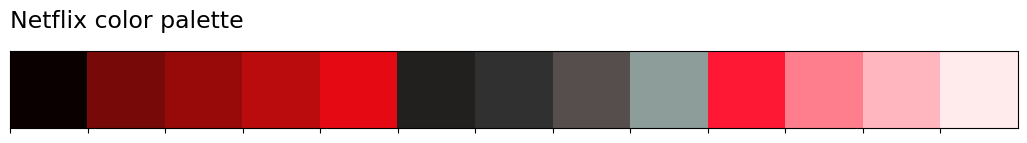

In [27]:
# Palette
sns.palplot(["#0b0000", "#780909", "#980a0a", "#ba0c0c", "#e50914", "#221f1f", "#303030", "#564d4d", "#8d9d9a", "#ff1833", "#ff7e8d", "#ffb6bf", "#ffeaec"]) 
plt.title("Netflix color palette ", loc="left", fontsize=17,y=1.2)
plt.show();

In [28]:
netflix_palette = ["#0b0000", "#780909", "#980a0a", "#ba0c0c", "#e50914", "#221f1f", "#303030", "#564d4d", "#8d9d9a", "#ff1833", "#ff7e8d", "#ffb6bf", "#ffeaec"]
sns.set_palette(netflix_palette)

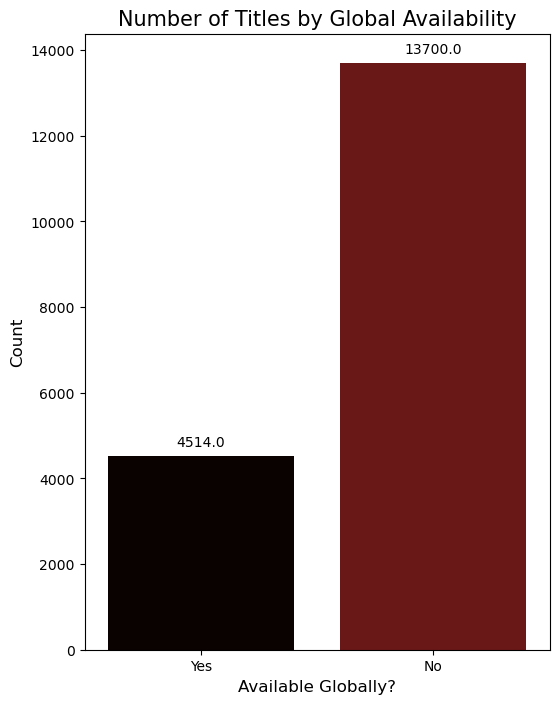

In [29]:
# Global Availability
plt.figure(figsize=(6, 8))
ax = sns.countplot(x=df["globalavailability"])
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()), ha="center", va="center", xytext=(0, 10), textcoords="offset points")
    
plt.xlabel("Available Globally?", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Number of Titles by Global Availability", loc="center", fontsize=15);

The majority of titles is not available globally.

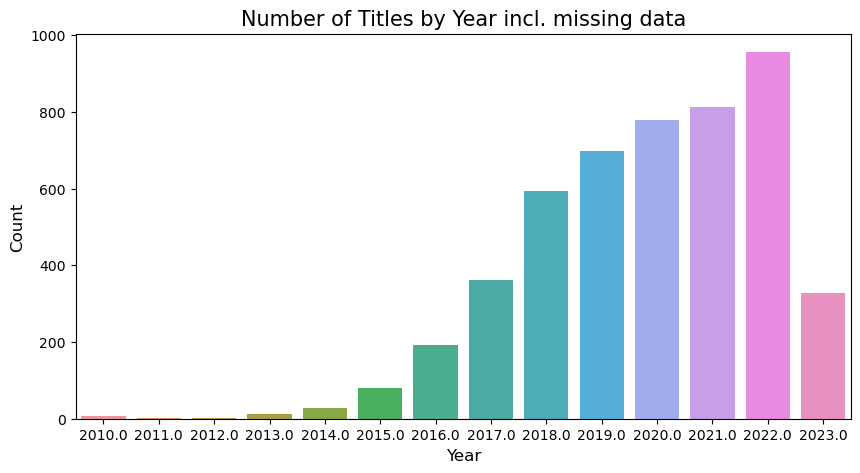

In [30]:
# Release Year
plt.figure(figsize=(10, 5))
sns.countplot (x = df["year"])
plt.xlabel("Year", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Number of Titles by Year incl. missing data", loc="center", fontsize=15);

The dataset contains titles that have been released between 2010 and 2023. Most titles in the dataset have been released in 2022.

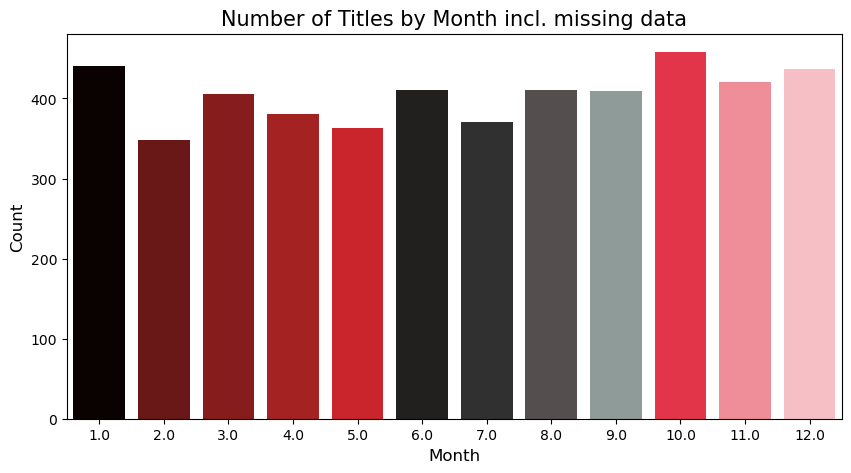

In [31]:
# Release Month
plt.figure(figsize=(10, 5))
sns.countplot(x=df["month"]) 
plt.xlabel("Month", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Number of Titles by Month incl. missing data", loc="center", fontsize=15);

Most titles in the dataset have been released in January and October. In February, the least amount of titles has been released.

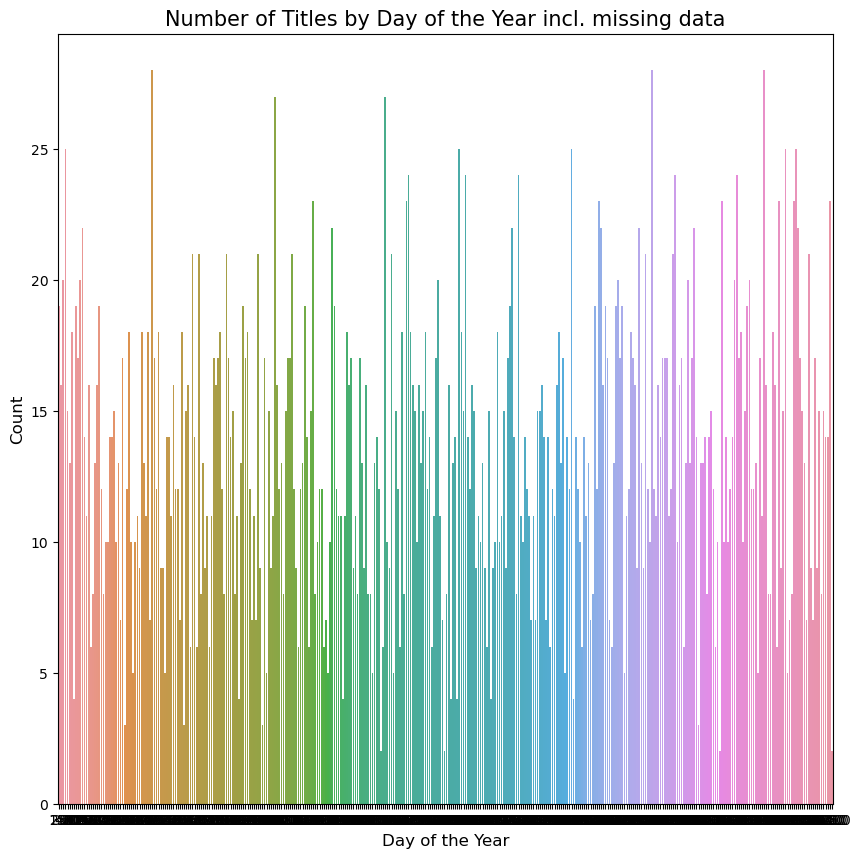

In [32]:
# Release dayoftheyear
plt.figure(figsize=(10, 10))
sns.countplot (x = df["dayoftheyear"])
plt.xlabel("Day of the Year", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Number of Titles by Day of the Year incl. missing data", loc="center", fontsize=15);

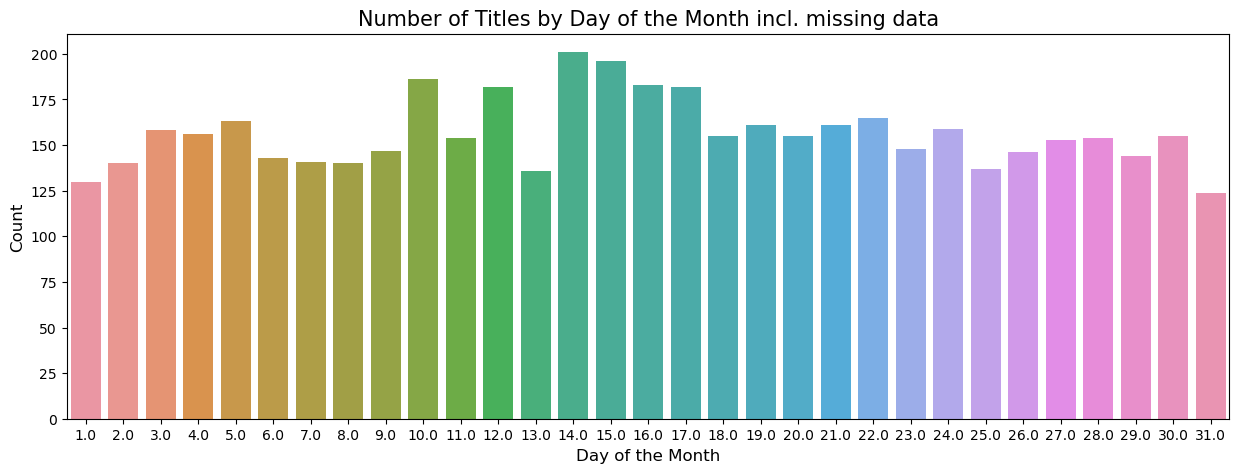

In [33]:
# Release dayofthemonth
plt.figure(figsize=(15, 5))
sns.countplot (x = df["dayofthemonth"])
plt.xlabel("Day of the Month", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Number of Titles by Day of the Month incl. missing data", loc="center", fontsize=15);

There is a small peak in releases in the mid of a month.

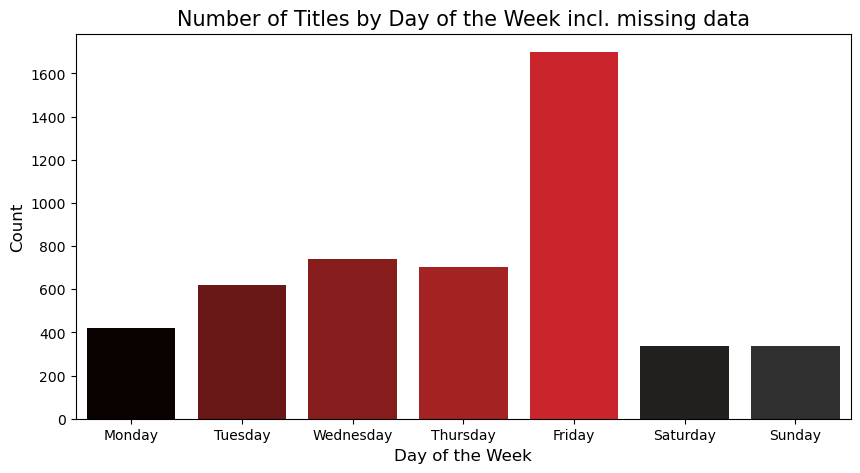

In [34]:
# Release dayoftheweek
plt.figure(figsize=(10, 5))
order_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.countplot (x = df["dayoftheweek"], order=order_days)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Number of Titles by Day of the Week incl. missing data", loc="center", fontsize=15);

The most popular day of the week for a release in the dataset was Friday.

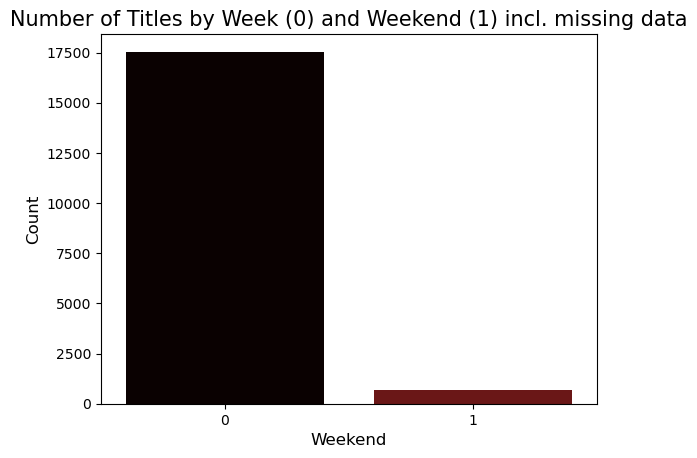

In [35]:
# Release weekday/weekend
sns.countplot (x = df["weekend"])
plt.xlabel("Weekend", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Number of Titles by Week (0) and Weekend (1) incl. missing data", loc="center", fontsize=15);

The titles were mostly released during the week (0) and not on the weekend (1).

In [36]:
print(df["hoursviewednumeric"].value_counts())

100000       3813
200000       1895
300000       1151
400000        823
500000        661
             ... 
56300000        1
56000000        1
55700000        1
55100000        1
812100000       1
Name: hoursviewednumeric, Length: 712, dtype: int64


We have only one title which has been a total amount of hours watched larger than 812 million hours. On the contrary, we have 3813 titles which have been least popular (total amount of hours viewed 100000).

In [37]:
print("Some of the position indicators of the variable 'hoursviewednumeric' are:")
print("mean:", df["hoursviewednumeric"].mean())
print("min:", df["hoursviewednumeric"].min())
print("max:", df["hoursviewednumeric"].max())
print("median:", df["hoursviewednumeric"].median())
print("mode:", df["hoursviewednumeric"].mode(), "\n")

print("Some of the dispersion indicators of the variable 'hoursviewednumeric' are:")
print("std:", df["hoursviewednumeric"].std())
print("var:", df["hoursviewednumeric"].var(), "\n")

print("The quartiles of of the variable 'hoursviewednumeric' are:")
print("Q1:", df["hoursviewednumeric"].quantile(q=0.25))
print("Q2:", df["hoursviewednumeric"].quantile(q=0.50))
print("Q3:", df["hoursviewednumeric"].quantile(q=0.75))

Some of the position indicators of the variable 'hoursviewednumeric' are:
mean: 5130954.211046448
min: 100000.0
max: 812100000.0
median: 700000.0
mode: 0   100000
Name: hoursviewednumeric, dtype: float64 

Some of the dispersion indicators of the variable 'hoursviewednumeric' are:
std: 18717672.236157846
var: 350351253940234.3 

The quartiles of of the variable 'hoursviewednumeric' are:
Q1: 200000.0
Q2: 700000.0
Q3: 3400000.0


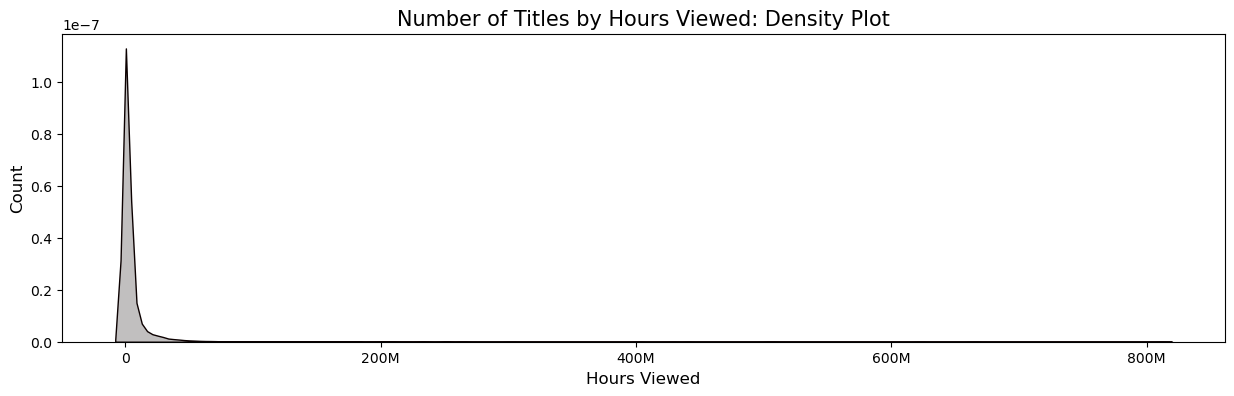

In [38]:
# Hours Viewed density plot
plt.figure(figsize=(15, 4))

sns.kdeplot (x = df["hoursviewednumeric"], fill=True)

def format_large_numbers(x, pos):
    if x >= 1e9:
        return f"{x / 1e9:.0f}B"
    elif x >= 1e6:
        return f"{x / 1e6:.0f}M"
    elif x >= 1e3:
        return f"{x / 1e3:.0f}K"
    else:
        return f"{x:.0f}"

plt.gca().xaxis.set_major_formatter(FuncFormatter(format_large_numbers))
plt.xlabel("Hours Viewed", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Number of Titles by Hours Viewed: Density Plot", loc="center", fontsize=15);


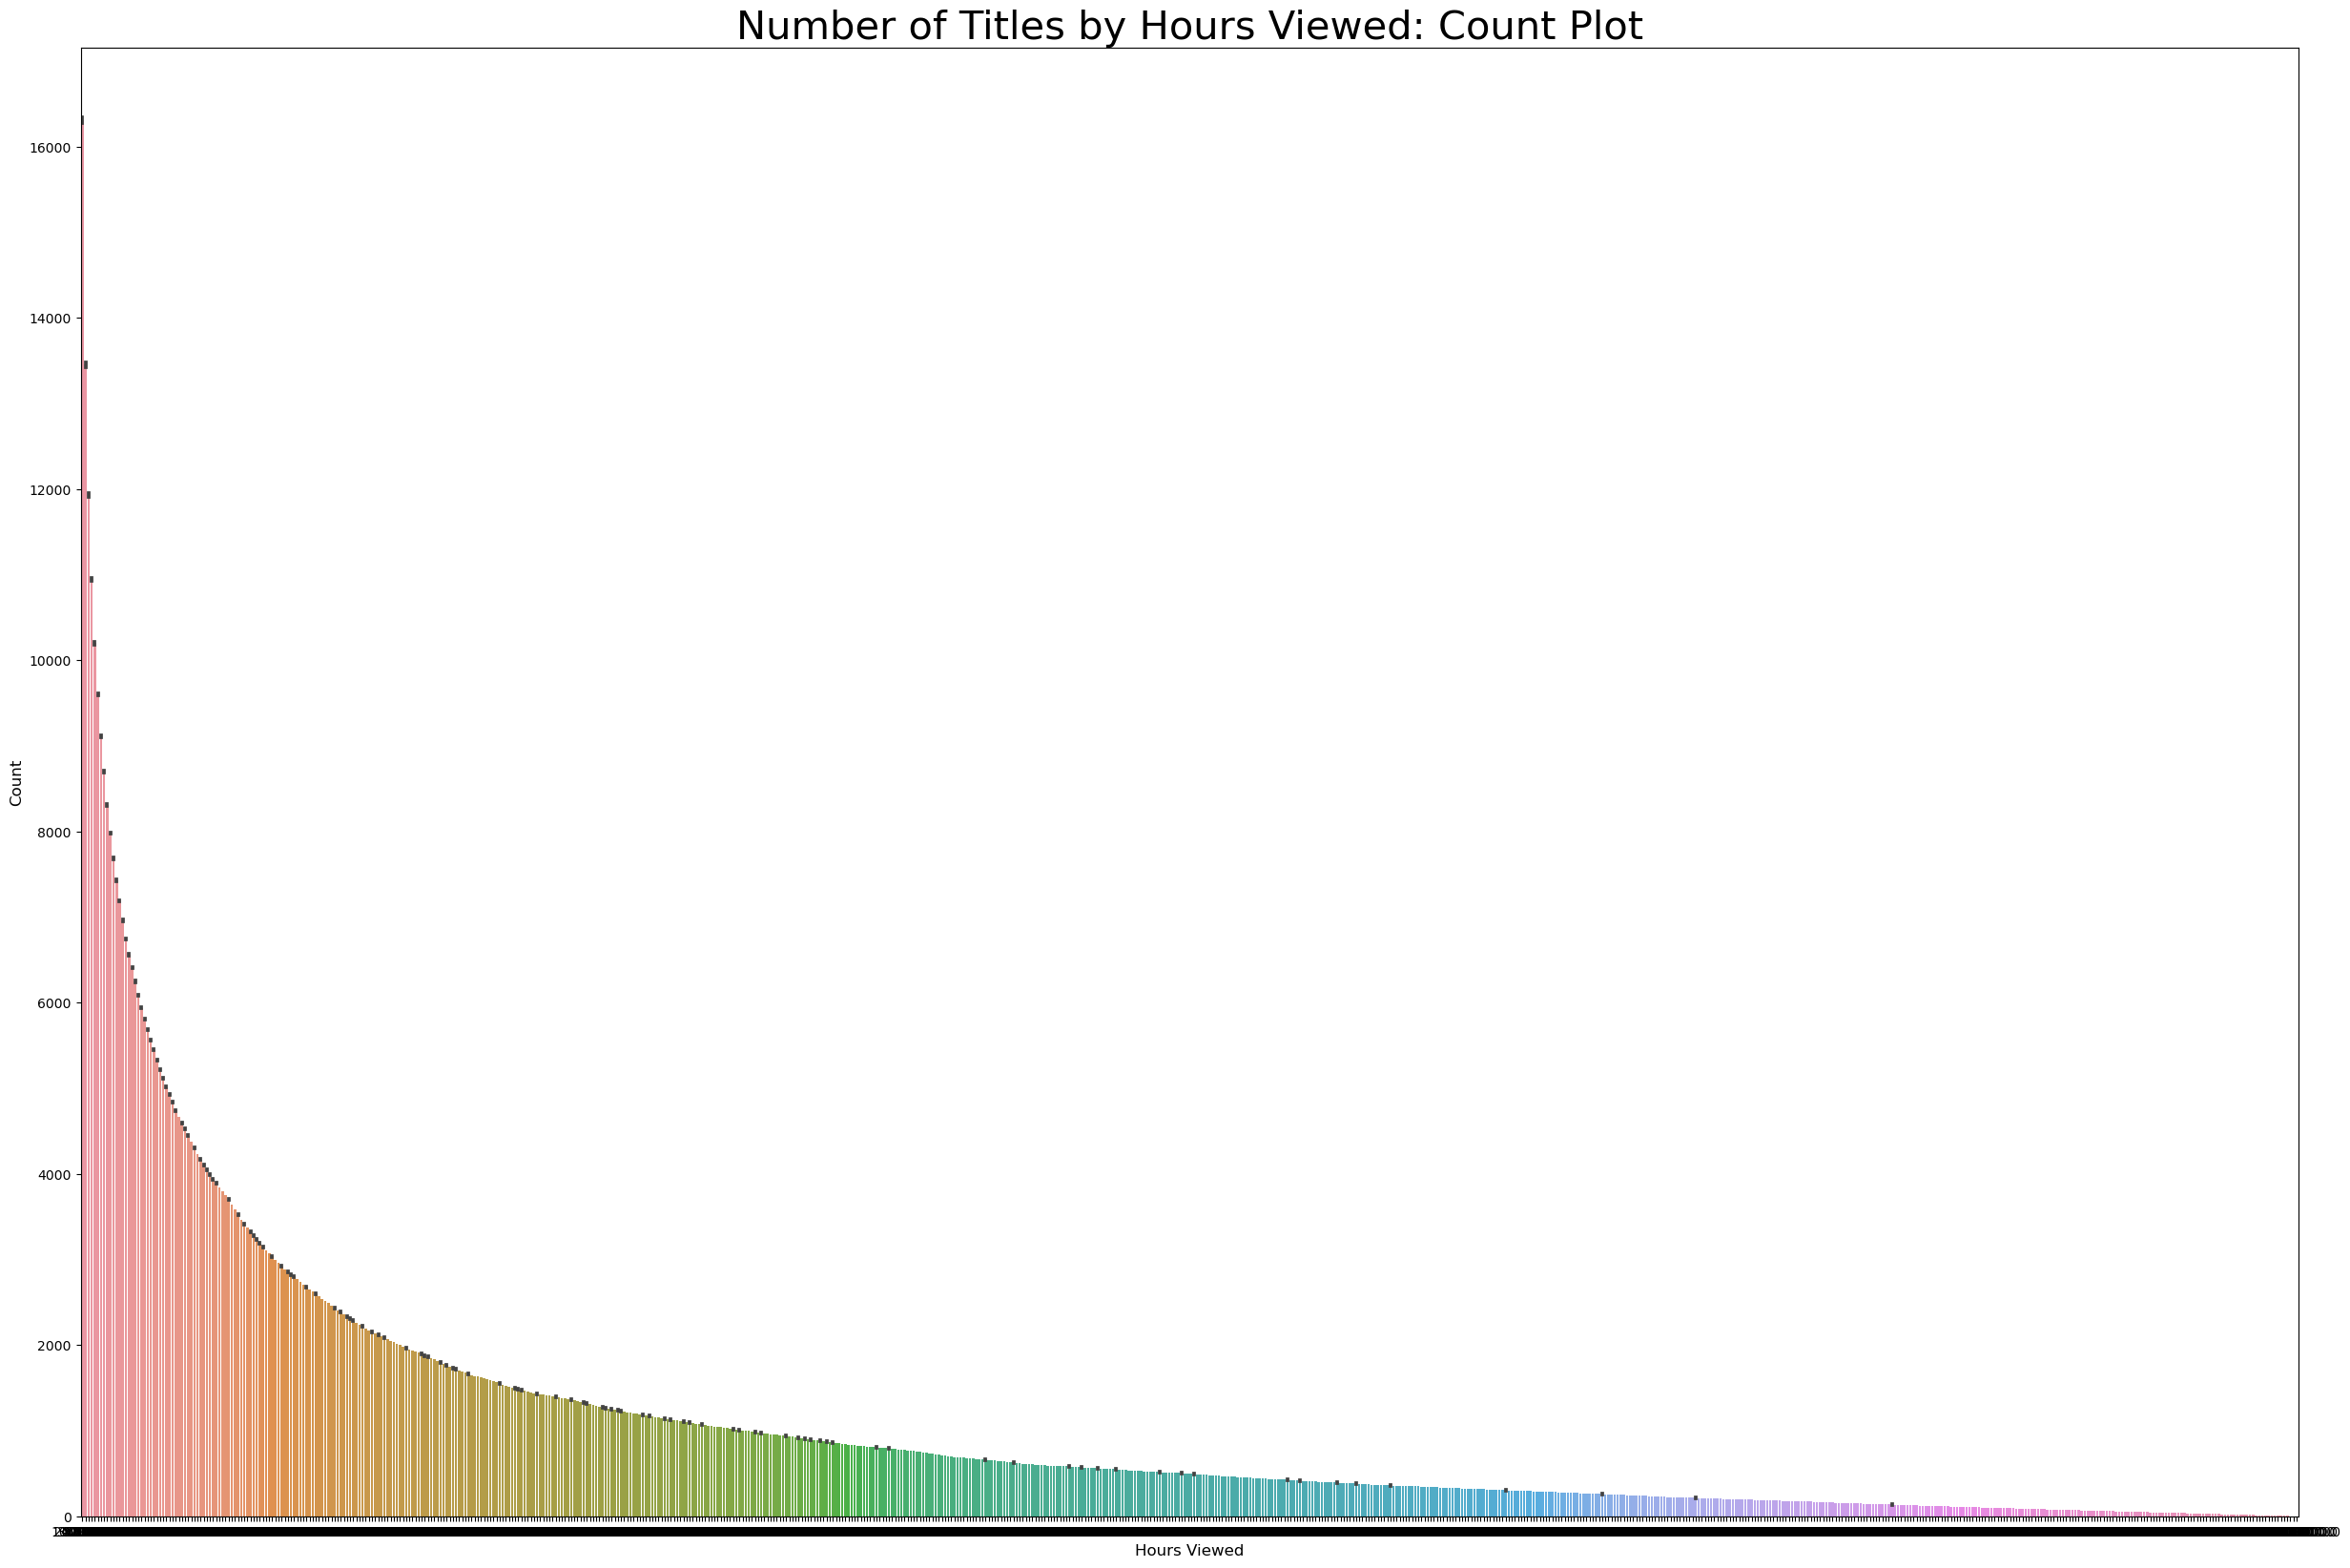

In [39]:
# Hours Viewed count plot
plt.figure(figsize=(30, 20))
sns.barplot(x=df["hoursviewednumeric"], y=df.index)
plt.xlabel("Hours Viewed", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Number of Titles by Hours Viewed: Count Plot", loc="center", fontsize=30);
plt.show();


The plot visualizes the descriptive result that we have many titles with a lower amount of hours viewed and only a couple of very popular titles.

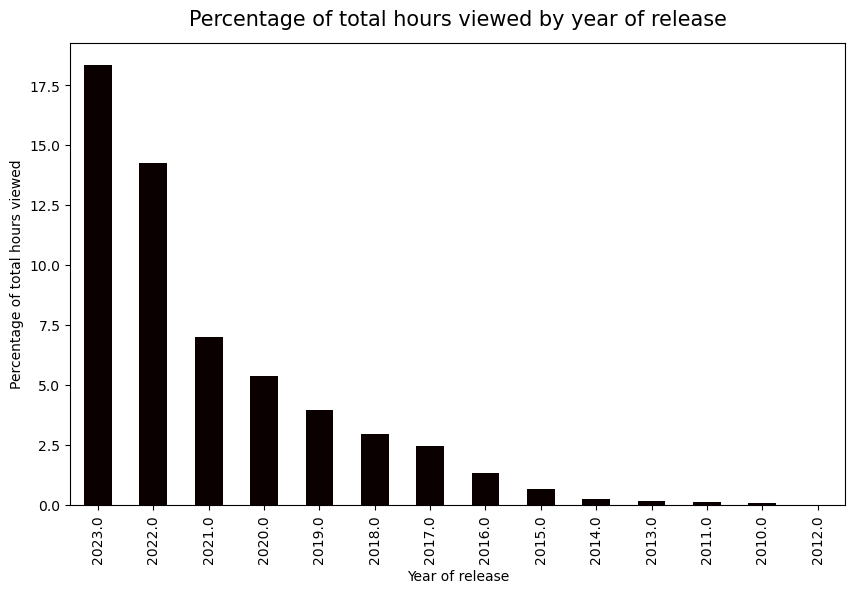

In [40]:
# Hours Viewed by release year
df["percentage"] = df["hoursviewednumeric"] / df["hoursviewednumeric"].sum() * 100

grouped_hoursviewed_releaseyear = df.groupby(df["year"])["percentage"].sum()
grouped_hoursviewed_releaseyear = grouped_hoursviewed_releaseyear.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
grouped_hoursviewed_releaseyear.plot(kind="bar")
plt.title("Percentage of total hours viewed by year of release", loc="center", fontsize=15, y=1.02)
plt.xlabel("Year of release")
plt.ylabel("Percentage of total hours viewed")
plt.show();

The most populat titles with the most hours viewed have been released in 2023 and 2022. This indicates that the top titles are new productions.

In [41]:
# Title with the most hours viewed:
print(df.loc[df["hoursviewednumeric"].idxmax()])
print("\n")

Title                        The Night Agent: Season 1
Available Globally?                                Yes
Release Date                                23.03.2023
Hours Viewed                               812.100.000
releasedatetime                    2023-03-23 00:00:00
year                                              2023
month                                                3
dayoftheyear                                        82
dayofthemonth                                       23
dayoftheweek                                  Thursday
weekday                                              3
weekend                                              0
globalavailability                                 Yes
globalavailability_binary                            1
hoursviewednumeric                           812100000
percentage                                           1
Name: 0, dtype: object




The title with the most hours viewed is "The Night Agent: Season 1", a show that is globally available. It has been released on March 23, 2023.

In [42]:
# Top 10 Titles with most hours viewed
df.groupby("Title")["hoursviewednumeric"].sum().nlargest(10)

Title
The Night Agent: Season 1             812100000
Ginny & Georgia: Season 2             665100000
The Glory: Season 1 // 더 글로리: 시즌 1    622800000
Wednesday: Season 1                   507700000
Queen Charlotte: A Bridgerton Story   503000000
You: Season 4                         440600000
La Reina del Sur: Season 3            429600000
Outer Banks: Season 3                 402500000
Ginny & Georgia: Season 1             302100000
FUBAR: Season 1                       266200000
Name: hoursviewednumeric, dtype: float64

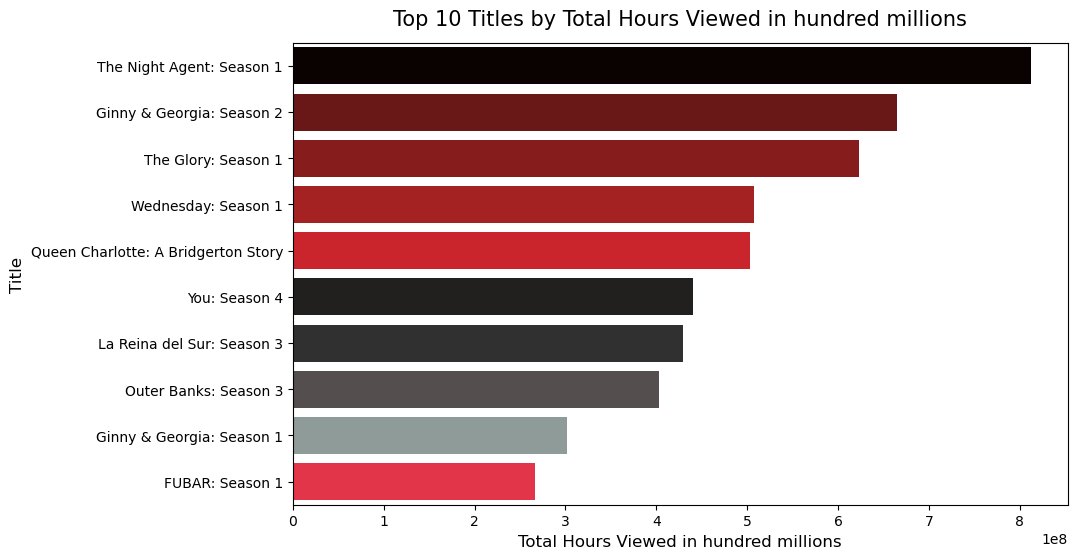

In [43]:
top_ten_titles = df.groupby("Title")["hoursviewednumeric"].sum().nlargest(10).reset_index()

# Plot the top ten titles
plot_df = top_ten_titles.copy()
plot_df["Title"] = plot_df["Title"].apply(lambda x: "The Glory: Season 1" if re.search(r"The Glory: Season 1", x) else x)

plt.figure(figsize=(10, 6))
sns.barplot(x="hoursviewednumeric", y="Title", data=plot_df)
plt.xlabel("Total Hours Viewed in hundred millions", fontsize=12)
plt.ylabel("Title", fontsize=12)
plt.title("Top 10 Titles by Total Hours Viewed in hundred millions", loc="center", fontsize=15, y=1.02)
plt.show();


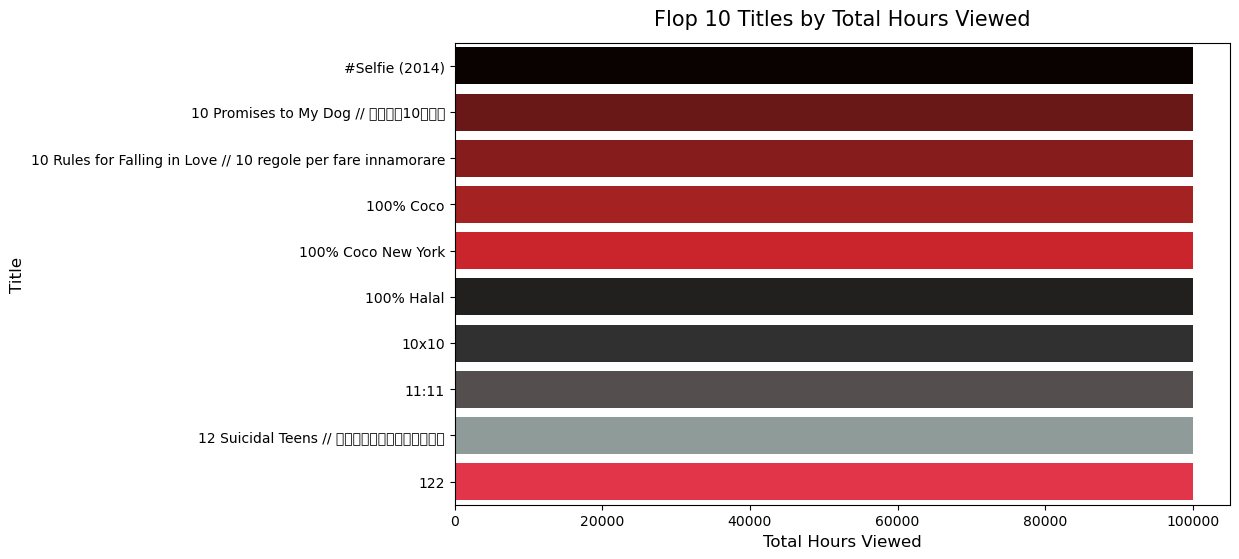

In [44]:
flop_ten_titles = df.groupby("Title")["hoursviewednumeric"].sum().nsmallest(10).reset_index()

# Plot the flop ten titles
plot_df_flop = flop_ten_titles.copy()

plt.figure(figsize=(10, 6))
sns.barplot(x="hoursviewednumeric", y="Title", data=plot_df_flop)
plt.xlabel("Total Hours Viewed", fontsize=12)
plt.ylabel("Title", fontsize=12)
plt.title("Flop 10 Titles by Total Hours Viewed", loc="center", fontsize=15, y=1.02)
plt.show();

In [45]:
# mean hours viewed by global availability 
hoursviewd_groupby_month_globalavailability = df.groupby([pd.Grouper(key = "releasedatetime", freq = "m"), 
                                                          df["globalavailability"]])\
                                                .agg({"hoursviewednumeric":"mean"}).unstack().fillna(0)

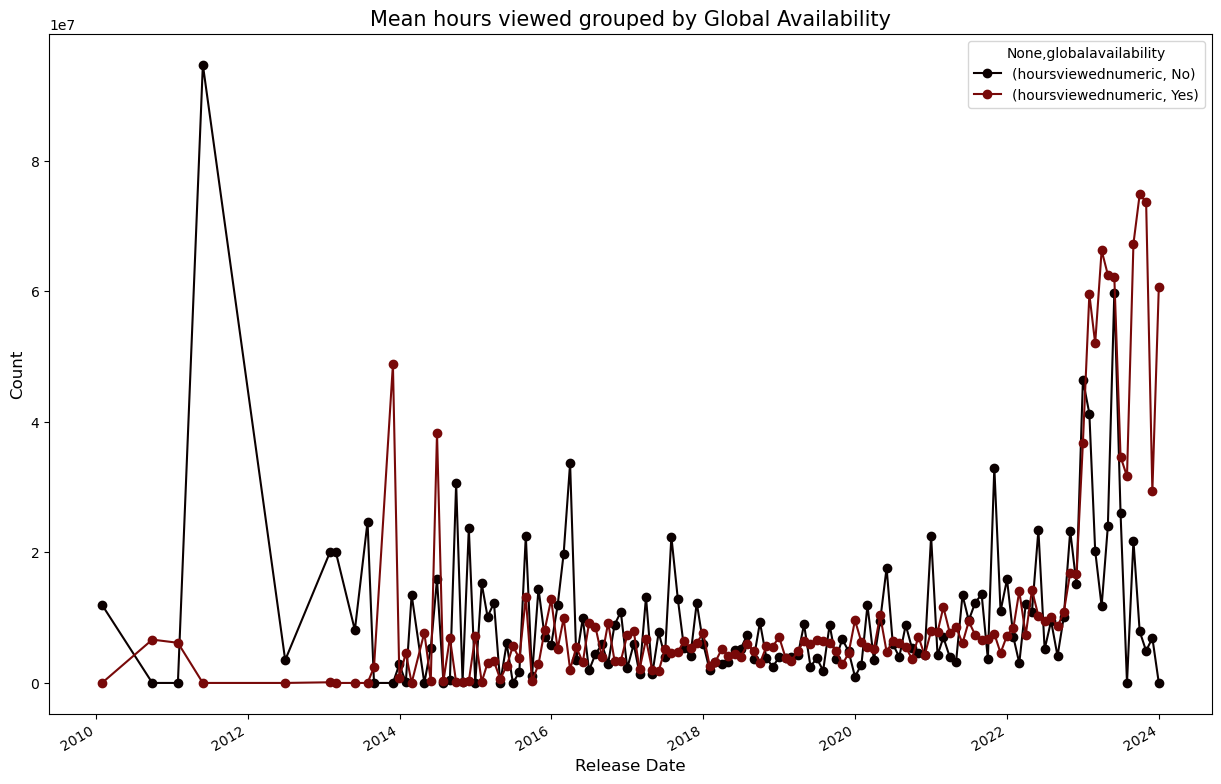

In [46]:
hoursviewd_groupby_month_globalavailability.plot(figsize = (15, 10), style = "o-")
plt.xlabel("Release Date", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Mean hours viewed grouped by Global Availability", loc="center", fontsize=15);

Interestingly, popular titles being released in 2012 were not globally available. Popular titles released between 2022 and 2023 are both, globally available and globally not available titles.

In [47]:
# What are the most frequent words in the title?
titles = df["Title"].dropna().astype(str)

custom_stop_words = set(["de", "la", "el"])
custom_chars_to_remove = set(["//", ":", "'s"])

# Tokenize, remove stop words, punctuation, numbers, non-English characters, and specific words
stop_words = set(stopwords.words())
all_words = [
    word.lower()
    for title in titles
    for word in word_tokenize(title)
    if word.lower() not in stop_words
    and word not in string.punctuation
    and not any(char.isdigit() for char in word)
    and all(ord(char) < 128 for char in word)
    and word.lower() not in custom_stop_words
    and word.lower() not in custom_chars_to_remove
]

word_counts = Counter(all_words)

                              
most_common_words = word_counts.most_common(30)
print("Most Common Words in Title:")
for word, count in most_common_words:
    print(f"{word}: {count}")

Most Common Words in Title:
season: 6025
series: 478
love: 425
part: 298
limited: 294
temporada: 219
movie: 208
life: 168
world: 162
house: 134
time: 129
christmas: 123
story: 114
black: 112
girl: 110
night: 101
big: 101
family: 92
high: 90
day: 90
friends: 87
girls: 86
show: 85
king: 84
city: 83
volume: 75
school: 75
secret: 75
great: 72
game: 71


The 10 most common words in the titles are season, series, love, part, limited, temporada, movie, life, world, and house.

# Statistical Analysis

In [48]:
df.head()

,Title,Available Globally?,Release Date,Hours Viewed,releasedatetime,year,month,dayoftheyear,dayofthemonth,dayoftheweek,weekday,weekend,globalavailability,globalavailability_binary,hoursviewednumeric,percentage
0,The Night Agent: Season 1,Yes,23.03.2023,812.100.000,2023-03-23,2023,3,82,23,Thursday,3,0,Yes,1,812100000,1
1,Ginny & Georgia: Season 2,Yes,05.01.2023,665.100.000,2023-05-01,2023,5,121,1,Monday,0,0,Yes,1,665100000,1
2,The Glory: Season 1 // 더 글로리: 시즌 1,Yes,30.12.2022,622.800.000,2022-12-30,2022,12,364,30,Friday,4,0,Yes,1,622800000,1
3,Wednesday: Season 1,Yes,23.11.2022,507.700.000,2022-11-23,2022,11,327,23,Wednesday,2,0,Yes,1,507700000,1
4,Queen Charlotte: A Bridgerton Story,Yes,04.05.2023,503.000.000,2023-04-05,2023,4,95,5,Wednesday,2,0,Yes,1,503000000,1


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18214 entries, 0 to 18213
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Title                      18214 non-null  object        
 1   Available Globally?        18214 non-null  object        
 2   Release Date               4855 non-null   object        
 3   Hours Viewed               18214 non-null  object        
 4   releasedatetime            4855 non-null   datetime64[ns]
 5   year                       4855 non-null   float64       
 6   month                      4855 non-null   float64       
 7   dayoftheyear               4855 non-null   float64       
 8   dayofthemonth              4855 non-null   float64       
 9   dayoftheweek               4855 non-null   object        
 10  weekday                    4855 non-null   float64       
 11  weekend                    18214 non-null  int32         
 12  glob

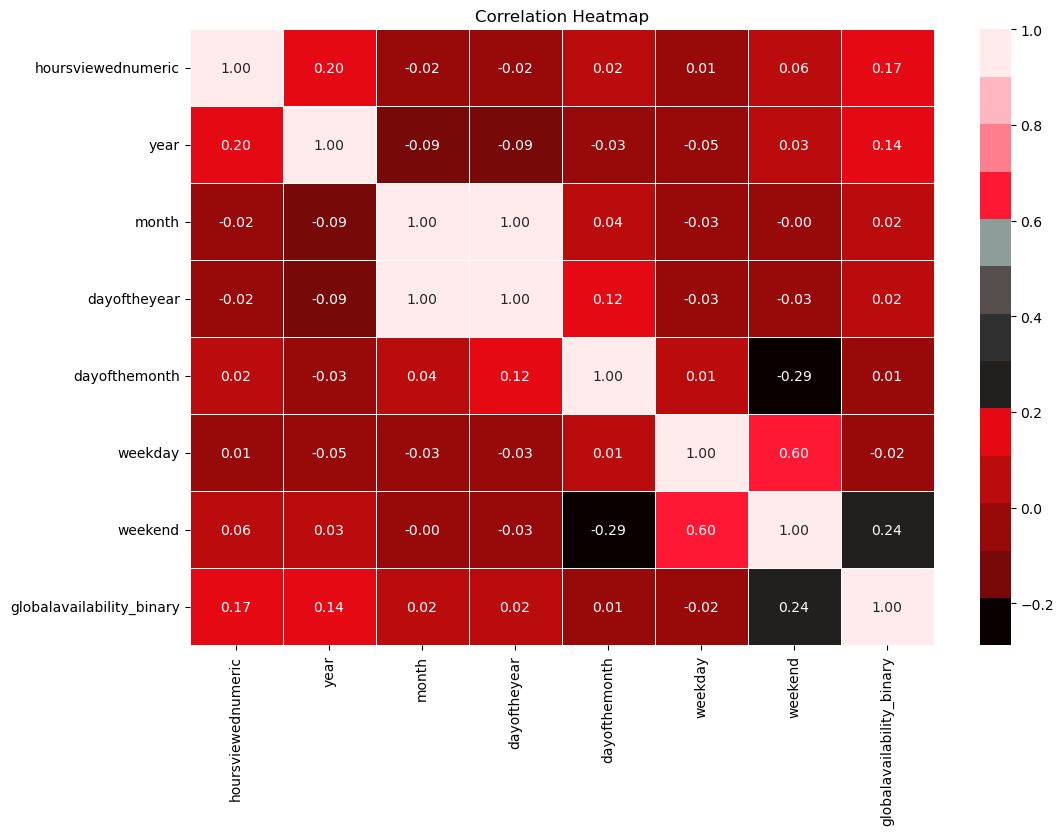

In [50]:
# Correlation matrix

columns_to_exclude = ["percentage"]
df_for_correlation = df.drop(columns=columns_to_exclude)

correlation_matrix = df_for_correlation.corr()

target_variable = "hoursviewednumeric"
correlation_matrix = correlation_matrix.reindex([target_variable] + (correlation_matrix.columns.drop(target_variable).tolist()), axis=1)
correlation_matrix = correlation_matrix.reindex([target_variable] + (correlation_matrix.index.drop(target_variable).tolist()))


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=sns.color_palette(netflix_palette), fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show();

There are no strong relationshiops between viewed hours and the other variables. The two most interesting are global availability, release on the weekend, and year of release. So we investigate these further.

In [51]:
# Relationship between Hours Viewed and Global Availability?

result_hours_availability = statsmodels.formula.api.ols("hoursviewednumeric ~ globalavailability_binary", data = df).fit()
print(statsmodels.api.stats.anova_lm(result_hours_availability))
print("\n")

print("Conclusion : The p-value (PR(>F)) is < 5% so we reject H0 and conclude H1.\
Hence we can conclude that the global availability has a significant influence on the viewed hours of a title.")


                             df              sum_sq            mean_sq   F  \
globalavailability_binary     1  183742560227247712 183742560227247712 540   
Residual                  18212 6197204827788571648    340281398407016 NaN   

                           PR(>F)  
globalavailability_binary       0  
Residual                      NaN  


Conclusion : The p-value (PR(>F)) is < 5% so we reject H0 and conclude H1.Hence we can conclude that the global availability has a significant influence on the viewed hours of a title.


In [52]:
# Relationship between Hours Viewed and Release on the weekend

result_hours_weekend = statsmodels.formula.api.ols("hoursviewednumeric ~ weekend", data = df).fit()
print(statsmodels.api.stats.anova_lm(result_hours_weekend))
print("\n")

print("Conclusion : The p-value (PR(>F)) is < 5% so we reject H0 and conclude H1.\
Hence we can conclude that the release on the weekend has a significant influence on the viewed hours of a title.")


            df              sum_sq           mean_sq   F  PR(>F)
weekend      1   24605550234724640 24605550234724640  70       0
Residual 18212 6356341837781085184   349019428826108 NaN     NaN


Conclusion : The p-value (PR(>F)) is < 5% so we reject H0 and conclude H1.Hence we can conclude that the release on the weekend has a significant influence on the viewed hours of a title.


In [53]:
# Relationship between Hours Viewed and Year of Release?

df_cleaned_lin1 = df.dropna(subset=["year", "hoursviewednumeric"])

X_lin1 = df_cleaned_lin1["year"]
y_lin1 = df_cleaned_lin1["hoursviewednumeric"]

X_lin1 = sm.add_constant(X_lin1)
model_lin1 = sm.OLS(y_lin1, X_lin1).fit()

print(model_lin1.summary())

print("\n")

print("Conclusion : The p-value (PR(>t)) is < 5% so we reject H0 and conclude H1.\
Hence we can conclude that the later a title has been released, \
the higher are the hours viewed of a title.")

                            OLS Regression Results                            
Dep. Variable:     hoursviewednumeric   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     193.2
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           4.23e-43
Time:                        10:15:49   Log-Likelihood:                -90757.
No. Observations:                4855   AIC:                         1.815e+05
Df Residuals:                    4853   BIC:                         1.815e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -6.07e+09   4.37e+08    -13.874      0.0

# Machine Learning: Decision Tree

Mean Squared Error: 295829592950491.3
R-squared: 0.07075370438386375


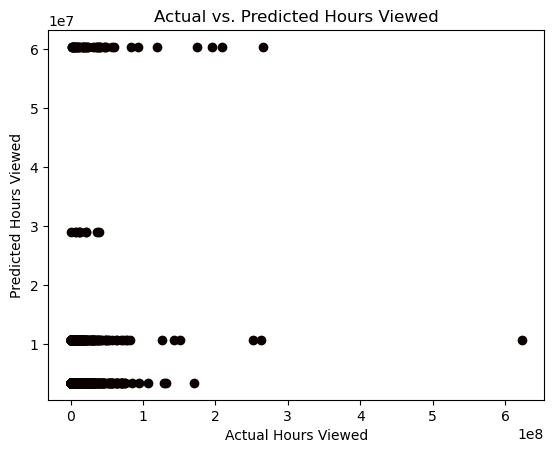

In [54]:
# Feature selection (X) and target variable (y)
X = df[["globalavailability_binary", "year", "weekend"]] 
y = df["hoursviewednumeric"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Impute missing data
imputer = SimpleImputer(strategy="mean")  # You can choose a different strategy
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Train the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(max_depth=2, random_state=42)
dt_regressor.fit(X_train_imputed, y_train)

# Make predictions on the test set
y_pred = dt_regressor.predict(X_test_imputed)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Visualize the predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Hours Viewed")
plt.ylabel("Predicted Hours Viewed")
plt.title("Actual vs. Predicted Hours Viewed")
plt.show();

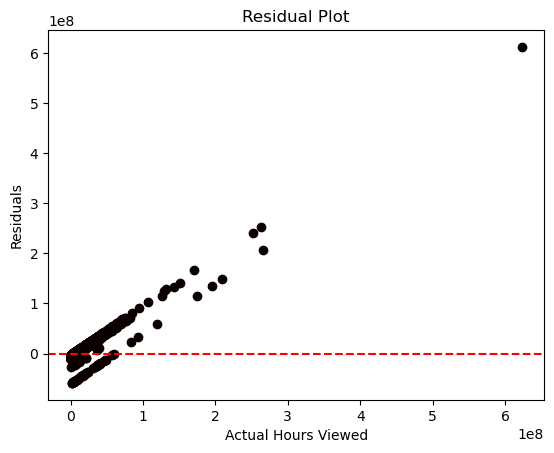

In [55]:
# Plot residuals
residuals = y_test - y_pred

plt.scatter(y_test, residuals)
plt.xlabel("Actual Hours Viewed")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(y=0, color="r", linestyle="--") 
plt.show();

In [56]:
# Get feature importances
feature_importances = dt_regressor.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

print(feature_importance_df);

                     Feature  Importance
1                       year           1
0  globalavailability_binary           0
2                    weekend           0


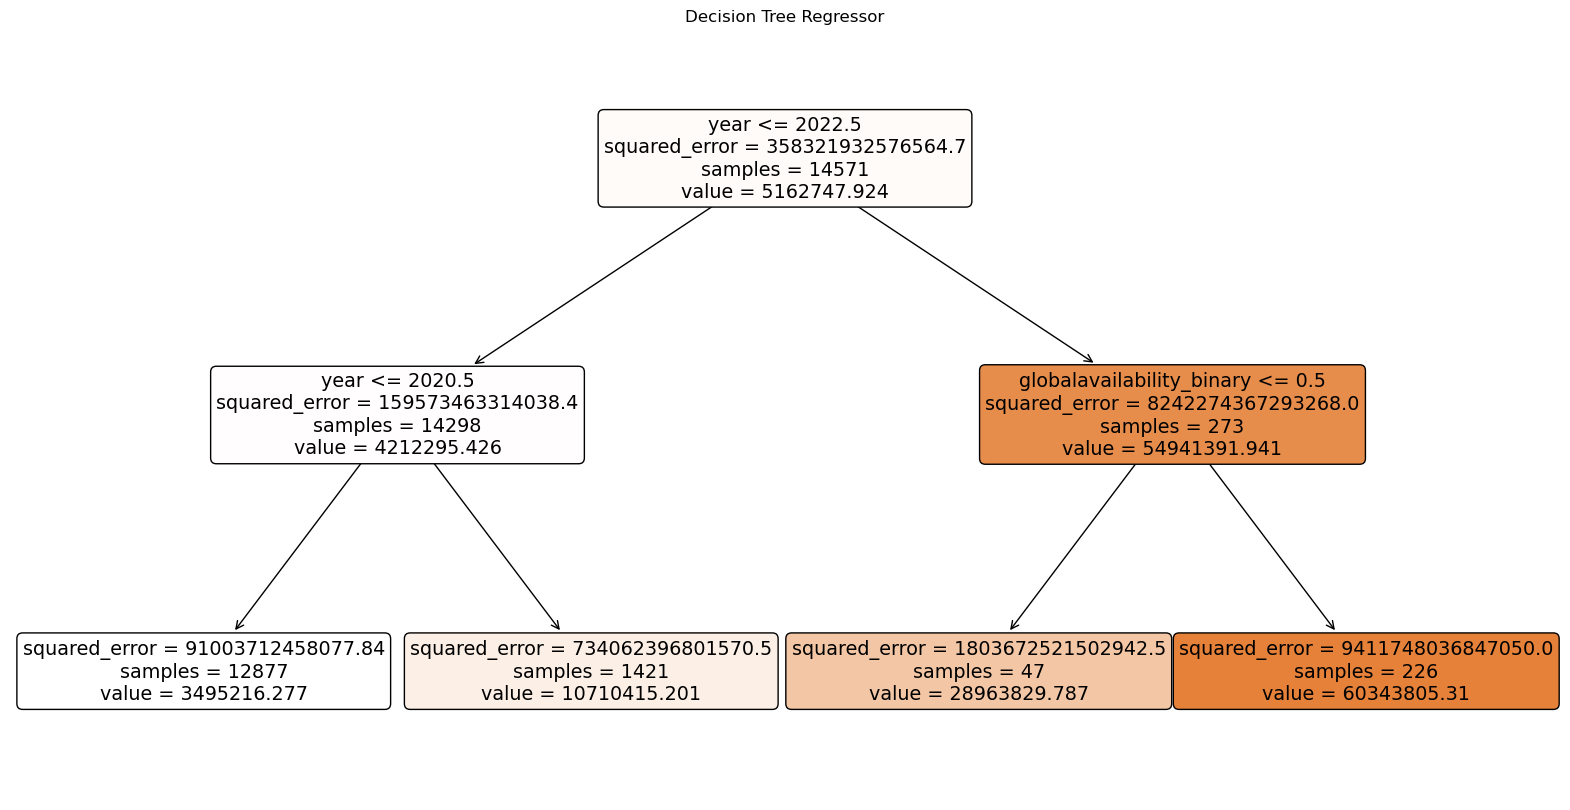

In [57]:
# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_regressor, feature_names=X.columns, filled=True, rounded=True)
plt.title("Decision Tree Regressor")
plt.show();